# Week6 Assignments (part 2)

In [12]:
from pathlib import Path
import os
import pandas as pd
import webbrowser
from IPython.display import display
from datetime import datetime
from typing import NamedTuple, Dict, Any, Callable, List
from unittest.mock import create_autospec
import shutil
import requests
from lightgbm import LGBMRegressor
from mlserver.codecs import PandasCodec
import warnings
import logging
import lightgbm

import mlflow
from mlflow import MlflowClient

from minio import Minio

from evidently import ColumnMapping
from evidently.report import Report
from evidently.test_suite import TestSuite
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
from evidently.tests import TestValueMAE
from evidently.ui.workspace import Workspace
from evidently.ui.remote import RemoteWorkspace

import kfp
from kfp.dsl import component, Input, Output, Dataset

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from utils.utils import (
    get_model_info,
    send_requests,
    init_evidently_project,
    check_snapshots,
    is_being_graded,
)
from utils.config import (
    MLFLOW_S3_ENDPOINT_URL,
    MLFLOW_TRACKING_URI,
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY, 
    REGISTERED_MODEL_NAME,
    STAGE_TAG_KEY,
    PROD_STAGE, 
    INPUTS_OUTPUTS_LOCAL_DIR_NAME,
    GROUND_TRUTH_LOCAL_DIR_NAME,
    FEATURE_STORE_DIR_NAME,
    INPUTS_OUTPUTS_BUCKET_NAME,
    GROUND_TRUTH_BUCKET_NAME,
    COLUMN_MAPPING_DICT,
    EVIDENTLY_MONITOR_URL
)
from utils.etl import etl

warnings.filterwarnings("ignore")

WORKING_DIR = Path.cwd()

# Suppress logging when grading the notebook
if is_being_graded():
    loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
    for logger in loggers:
        logger.setLevel(logging.ERROR)
    mlflow.utils.logging_utils.disable_logging()

assert kfp.__version__ == "2.0.1", "Incorrect version of kfp"
assert lightgbm.__version__ == "3.3.5", "Incorrect version of lightgbm"

## Assignment 2: The effect of retraining (2 points)
In this assignment, you'll gain an intuition of how retraining can affect model performance. You will experiment with two cases:
1. No retraining: Use the same model to predict data for each quarter of each year (2016-2019). 
1. Retraining with all available data: If the MAE is larger than the threshold of 40000 for one quarter, retrain the model using all available data (the old training data + data of of all the quarters up to and including the current quarter). Then use the retrained model to make predictions for the next quarter. 

More detailed instructions can be found later.

### Preparation

In [13]:
# MAE threshold that determines whether a model needs to be retrained
THRESHOLD = 40000

# The name of the directory where the raw data is saved
# The data is the same as the one used in week2 but split on a quarterly basis
RAW_DATA_DIR = "raw_data"

# Prepare the training data for the initial model
# We pre-processed all data in raw_data/reference using the etl function and saved the preprocessed data in the "feature_store_quarterly" directory in advance
x1 = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_X.parquet")
y1 = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / "0_0_y.csv")

# x2 and y2 were used as the testing data in previous assignments, here we also include it into the training data
x2 = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_X.parquet")
y2 = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_y.csv")
train_x = pd.concat([x1, x2])
train_y = pd.concat([y1, y2])

# Model hyperparameters (hyperparameter optimization was performed)
params = {
    "colsample_bytree" : 0.7,
    "learning_rate" : 0.075,
    "max_depth" : 50, 
    "min_child_samples" : 5,
    "min_split_gain" : 20.0,
    "n_estimators" : 1000,
    "num_leaves" : 100,
    "reg_lambda" : 50.0,
    "subsample" : 0.1,
    "random_state": 42
}

# Train the initial model
model = LGBMRegressor(**params)
model.fit(train_x, train_y)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.075, max_depth=50,
              min_child_samples=5, min_split_gain=20.0, n_estimators=1000,
              num_leaves=100, random_state=42, reg_lambda=50.0, subsample=0.1)

Next, let's use the `etl` function to feature-engineer the data used in the experiments beforehand. The `etl` function is adapted from the one used in the second week. The code below will uses the `etl` function to feature-engineer the data for each quarter of years 2016, 2017, 2018, and 2019. The engineered features will be stored in Parquet files under the `feature_store_quarterly` directory with a name of `<year>_<quarter>_X.parquet`. Similarly, the target CSV files will also be stored under the `feature_store_quarterly` directory with a name of `<year>_<quarter>_y.csv`. For example, the engineered features of data for the first quarter of 2016 will be saved in "2016_1_X.parquet" and the corresponding targets in "2016_1_y.csv". 

Please note that there are only three quarters of data for 2019. 

In [14]:
data_folders = sorted(
    [x for x in os.listdir(WORKING_DIR / RAW_DATA_DIR) if x != "reference"]
)  # ignore data in the "reference" directory as they were used to train the initial model and had already been feature_engineered

for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR / RAW_DATA_DIR / year))
    for quarter in quarter_folders:
        feature_file_name = f"{year}_{quarter}_X.parquet"
        target_file_name = f"{year}_{quarter}_y.csv"
        etl(
            path=WORKING_DIR / RAW_DATA_DIR / year / quarter,
            feature_store_path=WORKING_DIR / FEATURE_STORE_DIR_NAME,
            feature_file_name=feature_file_name,
            encoder_file_name="0_0.pkl",
            target_file_name=target_file_name,
            fit_encoder=False,
            targets_included=True,
        )

### 2a) No retraining

First, you only need to use the initial model to make predictions. For the data for every quarter of every year, you need to do the following:
1. Reading the engineered features and targets from the corresponding files (`<year>_<quarter>_X.parquet` and `<year>_<quarter>_y.csv`, respectively) in the "feature_store_quarterly" directory.
1. Using the initial model you trained above to make predictions on the features.
1. Calculating the MAE for each quarter of predictions. (You can assume that the targets and predictions are aligned, i.e., the $n^{th}$ target is the ground truth of the $n^{th}$ prediction.)
1. Append the calculated MAE to the `mae_no_retrain` list. 

In [15]:
mae_no_retrain = []

### START CODE HERE
# Load the initial model trained using the pre-processed training data
model = LGBMRegressor(**params)
model.fit(train_x, train_y)

# Iterate through the years (2016-2019) and quarters (1-4)
for year in range(2016, 2020):  # Iterate through 2016 to 2019
    for quarter in range(1, 5):  # Iterate through 1 to 4 quarters
        # Skip the 4th quarter of 2019 since it's not available
        if year == 2019 and quarter == 4:
            continue
        
        try:
            # Read the preprocessed feature and target files for the current quarter
            feature_file = f"{year}_{quarter}_X.parquet"
            target_file = f"{year}_{quarter}_y.csv"
            
            features = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / feature_file)
            targets = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / target_file)

            # Make predictions using the initial model
            predictions = model.predict(features)

            # Calculate the MAE for the current quarter
            mae = mean_absolute_error(targets, predictions)

            # Append the MAE to the list
            mae_no_retrain.append(mae)
        
        except FileNotFoundError:
            # If the quarter data doesn't exist, skip it
            continue

# Print the calculated MAEs
print(mae_no_retrain)
### END CODE HERE

[34295.65336684701, 33233.02337411714, 38046.28916851462, 48676.25072386749, 49755.63856583093, 57463.51904235105, 59334.29258769177, 62916.70701551576, 62510.755389636164, 62665.30933946348, 58759.15144709413, 57270.19692114742, 48338.759995999426, 47939.72190788014, 56976.407294967736]


### 2b) Retraining using all available data

Next, let's retrain our model when the MAE for a quarter is too large. Similar to what you did previously, for each quarter of each year, you need to:
1. Read the engineered features and targets from the corresponding files in the "feature_store_quarterly" directory.
1. Use the latest retrained model to make predictions on the features. If there is no retrained model, then just use the initial model you trained in the preparation part.
1. Calculate the MAE for the quarterly predictions. (You can assume that the targets and predictions are aligned, i.e., the $n^{th}$ target is the ground truth of the $n^{th}$ prediction.)
1. Append the MAE to the `mae_retrain_on_all` list. 
1. If the MAE is larger than the threshold of 40000, retrain the model using **all available data up to (and include) this point**. For example, if the MAE for the third quarter of 2016 is too large, then you can combine the initial `train_x` and the features in `feature_store_quarterly/2016/{1,2,3}_X.parquet` (Same applies to the targets.) to retrain the model. You can then use the retrained model to make predictions for the forth quarter. No hyperparameter optimization is needed. You can use the hyperparameters for training the initial model to retrain models.

In [16]:
mae_retrain_on_all = []

### START CODE HERE
# Start with the initial model trained on the first two quarters
model = LGBMRegressor(**params)
model.fit(train_x, train_y)

# Iterate through the years (2016-2019) and quarters (1-4)
for year in range(2016, 2020):  # Iterate through 2016 to 2019
    for quarter in range(1, 5):  # Iterate through 1 to 4 quarters
        # Skip the 4th quarter of 2019 since it's not available
        if year == 2019 and quarter == 4:
            continue
        
        try:
            # Read the preprocessed feature and target files for the current quarter
            feature_file = f"{year}_{quarter}_X.parquet"
            target_file = f"{year}_{quarter}_y.csv"
            
            features = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / feature_file)
            targets = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / target_file)

            # Make predictions using the latest model
            predictions = model.predict(features)

            # Calculate the MAE for the current quarter
            mae = mean_absolute_error(targets, predictions)

            # Append the MAE to the list
            mae_retrain_on_all.append(mae)
            
            # If the MAE is larger than the threshold, retrain the model with all available data
            if mae > THRESHOLD:
                print(f"Retraining model for {year} Q{quarter} (MAE = {mae})")
                
                # Collect all previous data up to this point
                retrain_x = train_x.copy()
                retrain_y = train_y.copy()

                for prev_year in range(2016, year + 1):  # Iterate through previous years
                    for prev_quarter in range(1, 5):  # Iterate through previous quarters
                        if prev_year == year and prev_quarter > quarter:
                            continue  # Skip future quarters
                        
                        # Load the features and targets for the previous quarters
                        prev_feature_file = f"{prev_year}_{prev_quarter}_X.parquet"
                        prev_target_file = f"{prev_year}_{prev_quarter}_y.csv"
                        
                        prev_features = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / prev_feature_file)
                        prev_targets = pd.read_csv(WORKING_DIR / FEATURE_STORE_DIR_NAME / prev_target_file)
                        
                        # Append the data to the retraining set
                        retrain_x = pd.concat([retrain_x, prev_features], ignore_index=True)
                        retrain_y = pd.concat([retrain_y, prev_targets], ignore_index=True)

                # Retrain the model with the updated data
                model.fit(retrain_x, retrain_y)
        
        except FileNotFoundError:
            # If the quarter data doesn't exist, skip it
            continue

# Print the calculated MAEs for retraining
print(mae_retrain_on_all)
### END CODE HERE

Retraining model for 2016 Q4 (MAE = 48676.25072386749)
Retraining model for 2017 Q2 (MAE = 44082.204746098796)
Retraining model for 2017 Q4 (MAE = 41636.44279518244)
[34295.65336684701, 33233.02337411714, 38046.28916851462, 48676.25072386749, 39929.696573082714, 44082.204746098796, 39154.49944567293, 41636.44279518244, 36788.722684772765, 37545.561976164856, 33579.16496991787, 34377.25004763687, 33474.75475444891, 32199.100648253883, 32050.422655336588]


In [17]:
assert len(mae_no_retrain) == 15 and len(mae_retrain_on_all) == 15, "The length of the lists is incorrect"

# The MAE breaks the threshold in the 4th quarter of 2016, so the first 4 values in the lists should be the same
assert mae_no_retrain[:4] == mae_retrain_on_all[:4], "The first 4 values in the lists should be the same"

for i in range(4, 15):
    assert mae_no_retrain[i] > mae_retrain_on_all[i], "From the 1st quarter of 2017, the MAE of the retrained model should be lower than the MAE of the model without retraining"

Now you can use the code provided below to generate a figure, which shows the MAE for each quarter of each year in both cases. The resulted figure should be similar to the one below:

<img src="./images/retrain_output.png" width=600 /> 

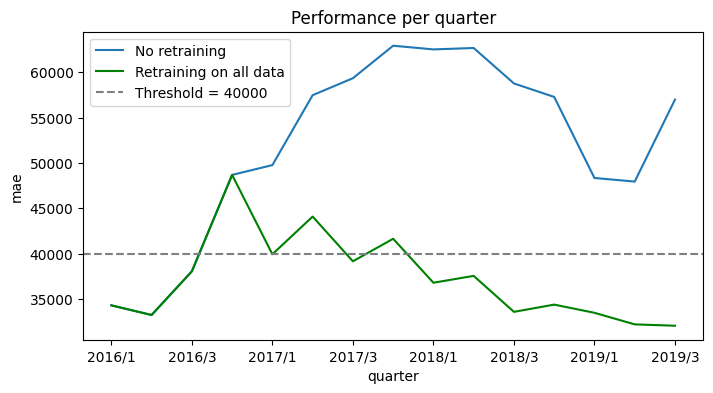

In [18]:
# Draw the figure
default_x_ticks = list(range(len(mae_no_retrain)))

# Values for x-axis
x_sticks = []
for year in data_folders:
    quarter_folders = sorted(os.listdir(WORKING_DIR / RAW_DATA_DIR / year))
    for q in quarter_folders:
        x_sticks.append(f"{year}/{q}")

plt.figure(figsize=(8, 4))
plt.plot(default_x_ticks, mae_no_retrain, label="No retraining")
plt.plot(default_x_ticks, mae_retrain_on_all, label="Retraining on all data", color="g")
plt.axhline(y=THRESHOLD, color="grey", linestyle="--", label=f"Threshold = {THRESHOLD}")
plt.xlabel("quarter")
plt.ylabel("mae")
plt.xticks(default_x_ticks, x_sticks)
plt.locator_params(axis="x", nbins=8)
plt.title("Performance per quarter")
plt.legend(loc="upper left")
plt.show()

## Assignment 3: Model-level monitoring with Evidently (4 points)
In this assignment, you'll use Evidently to monitor your model that predicts house price. The model will be monitored on a quarterly basis. 

### Preparation

In [19]:
# mlflow configuration
os.environ["MLFLOW_S3_ENDPOINT_URL"] = MLFLOW_S3_ENDPOINT_URL
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow_client = MlflowClient()

In [20]:
# Retrieve the on-production model version and its S3 URI
model_info = get_model_info()
if model_info is None:
    raise ValueError(
        "No model has been trained yet, please train a model by running the preparation part in part 1"
    )
MODEL_VERSION = model_info.model_version
MODEL_S3_URI = model_info.model_s3_uri
print(f"The model version is: {MODEL_VERSION}, its S3 URI is: {MODEL_S3_URI}")

The model version is: 2, its S3 URI is: s3://mlflow/11/66d2b291052147e08ad5b2feb32dd4f2/artifacts/lgbm-house


### 3a) Prepare reference data
Let's start by preparing the reference data. Please complete the `prep_ref` function that performs the following tasks:
1. Concatenating a given feature DataFrame (denoted as `x` in the function) and a target DataFrame (denoted as `y` in the function) into a single DataFrame. The concatenation should be performed horizontally (side by side). You can assume that the feature and target DataFrames are aligned (for $i^{th}$ row of the feature DataFrame, the corresponding target is also at $i^{th}$ row of the target DataFrame).
1. Adding a new column to the concatenated DataFrame named "prediction". The values in this column are generated by calling the predict method (`model.predict()`) of the provided model on `x`. Simply speaking, the function adds a column of predicted values to the DataFrame.

Finally, the function should return the concatenated DataFrame with the "prediction" column added. 

**Hint**: You may find the [pandas.DataFrame.concat](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.concat.html) function useful. 

In [21]:
def prep_ref(x: pd.DataFrame, y: pd.DataFrame, model: LGBMRegressor|mlflow.pyfunc.PyFuncModel) -> pd.DataFrame:
    """
    Prepare a reference data by combining features, targets, and the predictions made by the model
    Args:
        x: Feature DataFrame
        y: Target DataFrame
        model: The model used to make predictions on x
    Returns:
        Reference data (features+targets+predictions)
    """
    ### START CODE HERE
    # Concatenate features (x) and targets (y) horizontally
    ref_data = pd.concat([x, y], axis=1)
    
    # Generate predictions using the model
    if isinstance(model, LGBMRegressor):
        predictions = model.predict(x)
    elif isinstance(model, mlflow.pyfunc.PyFuncModel):
        # In case the model is an MLflow PyFuncModel, we use the predict method accordingly
        predictions = model.predict(x)
    else:
        raise ValueError("Unsupported model type")
    
    # Add the predictions as a new column in the DataFrame
    ref_data['prediction'] = predictions
    
    return ref_data
    ### END CODE HERE

Let's test if your `prep_ref` function works correctly by preparing a reference dataset used in this assignment. We will use model's testing data as the reference data. 

In [22]:
uploaded_model = mlflow.pyfunc.load_model(model_uri=MODEL_S3_URI)

# Read features and targets of the testing data
# We generated "1_0_X.parquet" and "1_0_y.csv" in advance by pre-processing the raw data in raw_data/reference/test using the etl function from the second week
test_x = pd.read_parquet(WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_X.parquet")
test_y = pd.read_csv(
    WORKING_DIR / FEATURE_STORE_DIR_NAME / "1_0_y.csv", index_col=False
)

current_ref_df = prep_ref(x=test_x, y=test_y, model=uploaded_model)
assert current_ref_df.shape == (
    2762,
    18,
), f"The shape of the reference DataFrame is incorrect"
assert set(current_ref_df.columns) == set(
    [
        "yr_built",
        "bedrooms",
        "postcode",
        "area",
        "bathrooms",
        "condition",
        "grade",
        "sqft_living",
        "sqft_lot",
        "sqft_basement",
        "sqft_living15",
        "sqft_lot15",
        "waterfront",
        "view",
        "distance",
        "year",
        "price",
        "prediction",
    ]
), "The columns of the reference DataFrame are incorrect"

display(current_ref_df.head())

,yr_built,bedrooms,postcode,area,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,year,price,prediction
0,1970.0,3.0,468060.054400,460458.275887,1.75,4,7.0,1590.0,20065.0,60.0,1675.0,17597.0,0.0,0.0,10.90,2009,300400.0,341136.698488
1,1940.0,4.0,600905.249689,600905.249689,2.00,4,7.0,1940.0,5798.0,190.0,1797.0,5213.0,0.0,0.0,1.00,2010,629700.0,620312.173953
2,1967.0,3.0,597736.921703,559758.748750,2.00,4,7.0,1555.0,8130.0,190.0,1814.0,8275.0,0.0,0.0,10.46,2010,425900.0,450438.854789
3,1977.0,4.0,468060.054400,472614.500499,2.00,3,8.0,2640.0,11091.0,1040.0,2342.0,10377.0,0.0,0.0,11.71,2011,486300.0,491924.641801
4,1980.0,3.0,597736.921703,579251.885253,2.00,4,7.0,1590.0,8421.0,330.0,1722.0,8486.0,0.0,0.0,9.68,2014,527500.0,510616.017204


Expected output:

<img src="./images/ref_data.png" />

Now, please complete the `upload_reference_data` function that uploads the reference data (a Parquet file) to MLflow. The file should be uploaded to a directory named "reference_data" under the MLflow Run that trains a registered model whose name is `registered_model_name` and whose version is `model_version`. `registered_model_name` and `model_version` are arguments given to the function.

<img src="./images/ref_data_mlflow_run.png" width=1000 />

**Hints**:
- [mlflow.start_run](https://mlflow.org/docs/2.9.2/python_api/mlflow.html#mlflow.start_run)
- [mlflow.log_artifact](https://mlflow.org/docs/2.9.2/python_api/mlflow.html#mlflow.log_artifact)
- [MlflowClient.get_model_version](https://mlflow.org/docs/2.9.2/python_api/mlflow.client.html#mlflow.client.MlflowClient.get_model_version)

In [23]:
def upload_reference_data(registered_model_name: str, model_version: str, x: pd.DataFrame, y: pd.DataFrame):
    """
    Prepare a reference data and store it under an MLflow Run as an artifact (a Parquet file).
    Args:
        registered_model_name and model_version: The name and version of the registered model. The reference data should be uploaded to the MLflow Run that trains this model
        x: A feature DataFrame
        y: A target DataFrame, x and y are used to generate the reference data
    """
    # Prepare the reference data and save it locally first
    loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{registered_model_name}/{model_version}")
    reference_df = prep_ref(x=x, y=y, model=loaded_model)
    reference_df.to_parquet("reference.parquet")

    artifact_path = "reference_data" # Use this as the run-relative artifact path when uploading the Parquet file of the reference data
    mlflow_client = MlflowClient()

    # TODO:
    # 1. Find the MLflow Run ID based on the given name and version of the registered model
    # 2. Upload the local reference.parquet to MLflow under the Run with the given mlflow_run_id
    ### START CODE HERE
    # 1. Get the run ID associated with the registered model version
    model_version_info = mlflow_client.get_model_version(registered_model_name, model_version)
    run_id = model_version_info.run_id

    # 2. Log the reference.parquet file as an artifact in the correct run
    with mlflow.start_run(run_id=run_id):  # Start the run using the identified run_id
        mlflow.log_artifact("reference.parquet", artifact_path=artifact_path)

    ### END CODE HERE

Let's test the `upload_reference_data` using the next code cell. You should see a file named "reference.parquet" is uploaded to a folder named "reference_data" under the MLflow Run that trains your model, like the example screenshot given in the instructions. (You probably need to update the MLflow UI to see the change.)

In [24]:
Path("reference.parquet").unlink(missing_ok=True) # Delete the old reference.parquet file
open("reference.parquet", "w").close() # Create a new one and make sure we have the write permission to the file

upload_reference_data(
    registered_model_name=REGISTERED_MODEL_NAME,
    model_version=MODEL_VERSION,
    x=test_x,
    y=test_y,
)


### 3b) Collect model inputs and outputs and combine them with ground truth
So far you've prepared the reference data for your model. The next step is to collect the production data so that we can monitor how the model performs on real-world data. Similar to reference data, the production data also contains: 1) model inputs (the features on which it makes predictions), 2) model outputs (the predictions), and 3) the ground truth of the inputs.

The inference service running on KServe receives inputs (features) and returns outputs (predictions). Your task is to complete the `collect_input` function that performs the following tasks:
1. Given an HTTP response returned by the inference service, extracting the predictions from the response and adding the predictions to the input feature DataFrame.
1. Saving the DataFrame containing both inputs and predictions to a CSV file. The input DataFrame has an index named "request_id", please include the index when you save the DataFrame to a CSV file. If the file already exists, the function appends the data to the existing file; otherwise, it creates a new file.

**Hints**:
- [os.path.isfile](https://docs.python.org/3.10/library/os.path.html#os.path.isfile)
- [pandas.DataFrame.to_csv](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.to_csv.html) (The `index_label`, `mode`, and `header` arguments might be useful.)

In [25]:
def collect_inputs_outputs(input_df: pd.DataFrame, response: requests.Response, inputs_outputs_file_path: str):
    """
    Adds the predictions returned from a web API response to an input DataFrame and saves the combined data (input features and predictions) to a CSV file
    Args:
        input_df: Input (feature) DataFrame
        response: The response (containing predictions) returned by an inference service
        inputs_outputs_file: The CSV file of the combined data, i.e., inputs(features)+outputs(predictions)
    """
    # Extract predictions and add them to the input DataFrame. We assume the predictions and inputs are aligned
    y_pred_list = response.json()["outputs"][0]["data"]
    input_df["prediction"] = y_pred_list
    
    ### START CODE HERE
    # Save the DataFrame to a CSV file, either by appending or creating a new file
    if os.path.isfile(inputs_outputs_file_path):
        # File exists, append without writing the header
        input_df.to_csv(inputs_outputs_file_path, mode="a", header=False, index=True, index_label="request_id")
    else:
        # File does not exist, create a new file with the header
        input_df.to_csv(inputs_outputs_file_path, mode="w", header=True, index=True, index_label="request_id")
    ### END CODE HERE

Let's test the `collect_inputs_outputs` function by running the following two code cells. In the next code cell, we'll simulate requests using the data from 2016, 2017, and 2018 and send these requests to the inference service. Each request contains 300 inputs (one feature row is one input). The data used for generating requests is saved in the "request_data" folder, which was generated beforehand so you don't need to worry about it. 

The next code cell should take less than 1min to complete. 

In [26]:
# The collected inputs and outputs for each quarter are saved in a separate file (inputs_outputs/<year>_<quarter>.csv)
# We collect data for years 17, 18, and 19. This data will be used in some other tasks later
for year in [2016, 2017, 2018]:
    for quarter in range(1, 5):
        # Delete possible existing inputs_outputs files for consistency
        inputs_outputs_path = (
            WORKING_DIR / INPUTS_OUTPUTS_LOCAL_DIR_NAME / f"{year}_{quarter}.csv"
        )
        if os.path.isfile(inputs_outputs_path):
            os.remove(inputs_outputs_path)

        inputs_df = pd.read_parquet(
            WORKING_DIR / "request_data" / f"{year}_{quarter}_X.parquet"
        )

        # Each request contains 300 inputs
        chunk_size = 300

        for i in range(0, inputs_df.shape[0], chunk_size):
            request_df = inputs_df.iloc[i : i + chunk_size]
            encoded_request_data = PandasCodec.encode_request(request_df).dict()
            response = send_requests(
                model_name="house-price", input=encoded_request_data["inputs"], count=1
            )
            collect_inputs_outputs(request_df, response, str(inputs_outputs_path))

In [27]:
# Check the shape of the collected inputs-outputs DataFrames
year = 2016
expected_row_count = [718, 796, 727, 972]
for quarter in range(1, 5):
    inputs_outputs_df = pd.read_csv(
        WORKING_DIR / INPUTS_OUTPUTS_LOCAL_DIR_NAME / f"{year}_{quarter}.csv",
        index_col="request_id",
    )
    assert inputs_outputs_df.shape == (expected_row_count[quarter-1], 17), f"The inputs-outputs DataFrame for quarter {quarter}, {year} is incorrect"

We have collected model inputs and outputs, let's look at how the collected data looks like.

In [28]:
inputs_outputs_sample_df = pd.read_csv(
    WORKING_DIR / INPUTS_OUTPUTS_LOCAL_DIR_NAME / f"2016_1.csv", index_col="request_id"
)
inputs_outputs_sample_df.head()

,yr_built,bedrooms,postcode,area,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,waterfront,view,distance,year,prediction
request_id,,,,,,,,,,,,,,,,,
6dba2e83-ece8-4950-850b-26bdbe3b788f,2014.0,4.0,554723.808334,566238.286455,3.0,3,9.0,3180.0,6098.0,10.0,2760.0,5602.0,0.0,0.0,11.72,2016,740576.785798
e9c5431e-5b9a-4dc6-abd7-6b279c1d49cc,1972.0,3.0,468060.054400,473825.061019,2.0,3,7.0,1760.0,6296.0,560.0,1694.0,6225.0,0.0,0.0,9.73,2016,412976.922068
c324f1a4-9fe6-4ab3-832c-3fbc4e3571b7,1986.0,4.0,554723.808334,534407.105101,2.0,4,9.0,2795.0,13426.0,0.0,2760.0,13107.0,0.0,0.0,12.94,2016,698439.798661
f0aa3ddb-ba19-4649-9c6a-e050d0e381ac,1979.0,4.0,468060.054400,473598.958080,2.5,4,8.0,2430.0,9383.0,860.0,2112.0,9577.0,0.0,0.0,10.42,2016,550642.388739
e24b4c37-f024-47c2-a5c3-8f0eca9b3abe,2005.0,4.0,574729.392575,562650.254282,2.0,3,8.0,2220.0,4136.0,30.0,1952.0,4140.0,0.0,0.0,14.41,2016,548954.466899


Expected output:

<img src="./images/inputs_outputs_sample.png" />

As we can see, the collected data includes the features that the model receives as inputs and the predictions the model returns as outputs. In addition, the DatFrame also has an index named "request_id". This index will be used to combine the ground truth (i.e., targets) with the inputs. 

Let's assume we've already collected the ground truth for each quarter of 2016 and saved them as CSV files in the "ground_truth" directory. The ground_truth data also has "request_id" index. Now, please complete the `combine_ground_truth` that performs the following tasks:
1. Reading inputs+outputs data (in the "inputs_outputs" directory) and the ground truth data from their files as DataFrames.
1. Using the "request_id" index to combine ground truth DataFrame with the inputs+outputs DataFrame. Please note that the ground truth may be collected in a different order than the corresponding inputs. 
1. Removing the "request_id" index from the combined DataFrame as the index may cause some issues with Evidently. 

The function should return a DataFrame the contains model inputs, outputs, and the ground truth. 

**Hint**:  The [pandas.DataFrame.merge](https://pandas.pydata.org/pandas-docs/version/1.5/reference/api/pandas.DataFrame.merge.html) function may be useful. 

In [29]:
def combine_ground_truth(year: int, quarter: int) -> pd.DataFrame:
    """
    Combine ground truth with the model inputs+outputs based on the "request_id" index
    Args:
        year and quarter: The time range of the data to be combined
    """
    
    # The inputs+outputs DataFrame
    inputs_outputs_df = pd.read_csv(
        WORKING_DIR / INPUTS_OUTPUTS_LOCAL_DIR_NAME / f"{year}_{quarter}.csv",
        index_col="request_id",
    )

    # The ground truth DataFrame
    ground_truth_df = pd.read_csv(
        WORKING_DIR / GROUND_TRUTH_LOCAL_DIR_NAME / f"{year}_{quarter}_y.csv",
        index_col="request_id",
    )

    ### START CODE HERE
    # Combine the two DataFrames based on the "request_id" index
    combined_df = inputs_outputs_df.merge(ground_truth_df, left_index=True, right_index=True)

    # Remove the "request_id" index
    combined_df = combined_df.reset_index(drop=True)
    return combined_df
    ### END CODE HERE

In [30]:
# Check the shapes of the combined DataFrames (inputs+outputs+ground truth) are correct
for quarter in range(1, 5):
    prod_df = combine_ground_truth(year=2016, quarter=quarter)
    assert prod_df.shape == (expected_row_count[quarter-1], 18), f"The prod_df for quarter {quarter}, {year} is incorrect"

### 3c) Get on-production model version and the corresponding MLflow Running ID
In reality, the on-production model is not fixed, new model version will be deployed to replace the old one. Please complete the `get_production_model_version` function that uses the name of the registered model to retrieve the on-production model version (the model that has a {"stage": "Production"} tag). You can assume that only one model for predicting house price can be in the "Production" stage at any given time. 

Hint: [MLflowClient.search_model_versions](https://mlflow.org/docs/2.9.2/python_api/mlflow.client.html#mlflow.client.MlflowClient.search_model_versions)

In [31]:
### START CODE HERE
def get_production_model_version(registered_model_name: str) -> str:
    """
    Retrieve the version of the on-production model for a given registered model.
    
    Args:
        registered_model_name: The name of the registered model
    
    Returns:
        The version of the on-production model as a string
    """

    
    try:
        # Search for all versions of the given registered model
        model_versions = mlflow_client.search_model_versions(f"name='{registered_model_name}'")
        
        # Find the version with stage "Production"
        for mv in model_versions:
            if mv.current_stage == "Production":
                return mv.version
        
        # If no production model is found, raise an exception
        raise ValueError(f"No model is currently in 'Production' stage for {registered_model_name}")

    except Exception as e:
        print(f"Error retrieving production model version: {e}")
        raise

### END CODE HERE

In [32]:
model_version_output = get_production_model_version(REGISTERED_MODEL_NAME)
print(model_version_output)

assert model_version_output == f"{REGISTERED_MODEL_NAME}-{MODEL_VERSION}", "The model version is incorrect"

2


AssertionError: The model version is incorrect

### 3d) Monitor model performance and drift using Evidently
First, complete the `prep_report` function that produces an Evidently Report using the following Metric Presets: `RegressionPreset`, `TargetDriftPreset` and `DataDriftPreset`. (Use the default configurations of these Presets.) The Report should also have a list of tags and a timestamp. The tags and timestamp are specified as the function's arguments. 

In [33]:
def prep_report(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime, column_mapping_dict: Dict[str, Any]) -> Report:
    """
    Generate an Evidently Report of regression performance, target drift and data drift
    Args:
        prod_df: Production DataFrame (model inputs+outputs+ground truth) to be monitored
        ref_df: Reference DataFrame 
        tags: Tags of the Evidently Report
        timestamp: Timestamp of the Evidently Report
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    Returns:
        Evidently Report
    """
    # The column mapping that Evidently needs
    column_mapping = ColumnMapping(**column_mapping_dict)

    ### START CODE HERE
    # Create the Evidently report with the specified preset metrics
    report = Report(metrics=[
        RegressionPreset(),  # Handles regression performance metrics
        TargetDriftPreset(),  # Monitors target drift
        DataDriftPreset(),  # Monitors data drift
    ], 
    tags=tags,  # Pass tags directly to the Report
    timestamp=timestamp)  # Pass timestamp directly to the Report

    # Run the report to compare the reference data and production data
    report.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)

    # Return the final report object
    return report
    ### END CODE HERE


Let's test if the `prep_report` function can generate the correct Evidently Report. 

In [34]:
# Generate a Report for the third quarter of 2016
prod_df = combine_ground_truth(year=2016, quarter=3)
ref_df = pd.read_parquet("reference.parquet") #"reference.parquet" was created when running the upload_reference_data function

report = prep_report(prod_df=prod_df, 
            ref_df=ref_df, 
            tags=["2016-quarter3"], 
            timestamp=datetime(year=2016, month=10, day=1),
            column_mapping_dict=COLUMN_MAPPING_DICT)

report.save_html("report.html")

In [35]:
# The Report should contain the correct metrics, tags and timestamps
assert set([k["metric"] for k in report.as_dict().get("metrics")]) == set(
    [
        "RegressionQualityMetric",
        "RegressionPredictedVsActualScatter",
        "RegressionPredictedVsActualPlot",
        "RegressionErrorPlot",
        "RegressionAbsPercentageErrorPlot",
        "RegressionErrorDistribution",
        "RegressionErrorNormality",
        "RegressionTopErrorMetric",
        "RegressionErrorBiasTable",
        "ColumnDriftMetric",
        "ColumnValuePlot",
        "ColumnCorrelationsMetric",
        "ColumnDriftMetric",
        "ColumnCorrelationsMetric",
        "TargetByFeaturesTable",
        "DatasetDriftMetric",
        "DataDriftTable",
    ]
), "The Report should contain the correct metrics"
assert report.tags == ["2016-quarter3"], "The Report should contain the correct tag"
assert report.timestamp == datetime(2016, 10, 1, 0, 0), "The Report should contain the correct timestamp"

# Open the report.html you produced and the example one, they should be the same
if not is_being_graded():
    webbrowser.open("file:///" + str(WORKING_DIR / "report.html"))
    webbrowser.open(
        "file:///" + str(WORKING_DIR / "sample_monitoring_results" / "report.html")
    )

0:164: execution error: File some object wasn’t found. (-43)


Next, complete the `prep_regression_test` that produces an Evidently TestSuite. The TestSuite should include only one individual test for testing MAE (of the production data).  The test should fail if the MAE is not less than 40000. The TestSuite should also have a list of tags and a timestamp. The tags and timestamp are specified as the function's arguments. 

You may find the `TestValueMAE` test helpful. The use of `TestValueMAE` is the same as `TestValueR2Score` in the tutorial. You can use `lt<threshold` (lt means "less than") as the argument to specify the test criterion. 

In [36]:
def prep_regression_test(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime, column_mapping_dict: Dict[str, Any]) -> TestSuite:
    """
    Generate a Evidently TestSuite of MAE
    Args:
        prod_df: Production DataFrame (model inputs+outputs+ground truth) to be monitored
        ref_df: Reference DataFrame (the one uploaded to MLflow)
        tags: Tags of the Evidently report
        timestamp: Timestamp of the Evidently report
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    Returns:
        Evidently TestSuite
    """
    # The column mapping that Evidently needs
    column_mapping = ColumnMapping(**column_mapping_dict)

    ### START CODE HERE
    # Create a TestSuite and add the TestValueMAE test with the correct value argument
    test_suite = TestSuite(tests=[
        TestValueMAE(lt=40000)  # The test will fail if MAE is greater than 40,000
    ], 
    tags=tags,  # Set the tags for the TestSuite
    timestamp=timestamp)  # Set the timestamp for the TestSuite

    # Run the TestSuite against the reference and production data
    test_suite.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)

    # Return the final TestSuite object
    return test_suite
    ### END CODE HERE

Let's test if the `prep_regression_test` function can generate the correct Evidently Test Suite. 

In [37]:
regression_test = prep_regression_test(prod_df=prod_df, 
                     ref_df=ref_df, 
                     tags=["2016-quarter3"], 
                     timestamp=datetime(year=2016, month=10, day=1),
                     column_mapping_dict=COLUMN_MAPPING_DICT
                    )
regression_test.save_html("regression_test.html")

In [38]:
test_config = regression_test.as_dict().get("tests")
assert (
    len(test_config) == 1 and test_config[0]["name"] == "Mean Absolute Error (MAE)"
), "The TestSuite should only have one test for MAE"
assert (
    test_config[0]["parameters"]["condition"]["lt"] == 40000
), "The TestSuite should test if the MAE is less than 40000"
summary = regression_test.as_dict().get("summary")
assert summary["failed_tests"] == 1, "The test should fail"

if not is_being_graded():
    # Open the regression_test.html you produced and the example one, they should be the same
    webbrowser.open("file:///" + str(WORKING_DIR / "regression_test.html"))
    webbrowser.open(
        "file:///"
        + str(WORKING_DIR / "sample_monitoring_results" / "regression_test.html")
    )

0:173: execution error: File some object wasn’t found. (-43)


Then, complete the `monitor` function that performs the following tasks:
1. Calling `prep_report` and `prep_regression_test` to generate an Evidently Report and TestSuite for a given production dataset.
1. Pushing the Report and Test to a given Evidently Workspace.

In [39]:
ref_df = pd.read_parquet("reference.parquet") # Use this as the reference data for the monitoring

def monitor(
    evidently_workspace: Workspace,
    evidently_project_id: str,
    column_mapping_dict: Dict[str, Any], 
    prod_df: pd.DataFrame,
    prod_model_version: str,
    year: int,
    quarter: int
):  
    """
    Generate an Evidently Report and TestSuite for a given production dataset and push them to a given Evidently Workspace.
    Args:
        evidently_workspace and evidently_project_id: The Evidently Workspace and the ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
        prod_df: The production DataFrame to be monitored
        prod_model_version: The on-production model version to be monitored
        year and quarter: The time range of the data to be monitored
    """
    # Prepare tags for the Report and TestSuite
    time_tag = f"{year}-quarter{quarter}"
    tags = [time_tag, prod_model_version]

    # Prepare timestamp for the Report and TestSuite, assuming the monitoring results are generated on the first day of next quarter
    timestamp = None
    if quarter < 4:
        timestamp = datetime(year=year, month=quarter*3+1, day=1)
    elif quarter == 4:
        timestamp = datetime(year=year+1, month=1, day=1)

    ### START CODE HERE
     # Generate the Evidently Report using prep_report
    report = prep_report(
        prod_df=prod_df,
        ref_df=ref_df,
        tags=tags,
        timestamp=timestamp,
        column_mapping_dict=column_mapping_dict
    )

    # Generate the Evidently Regression TestSuite using prep_regression_test
    regression_test = prep_regression_test(
        prod_df=prod_df,
        ref_df=ref_df,
        tags=tags,
        timestamp=timestamp,
        column_mapping_dict=column_mapping_dict
    )



    # Convert column_mapping_dict to ColumnMapping if it's not already
    column_mapping = ColumnMapping(column_mapping_dict)


    # Upload the Report to the Workspace
    evidently_workspace.add_report(project_id=evidently_project_id, report=report)
    print(f"Successfully uploaded the Report for {time_tag} ({prod_model_version})")

    # Upload the TestSuite to the Workspace
    evidently_workspace.add_test_suite(project_id=evidently_project_id, test_suite=regression_test)
    print(f"Successfully uploaded the TestSuite for {time_tag} ({prod_model_version})")
    ### END CODE HERE

In [40]:
# Create a local Evidently monitoring workspace and initialize a project
local_workspace_name = "evidently_workspace"
local_project_name = "house-price-model-monitoring"

shutil.rmtree(WORKING_DIR / local_workspace_name / local_project_name, ignore_errors=True)

local_workspace = Workspace.create(str(WORKING_DIR / local_workspace_name))

local_house_price_project = init_evidently_project(
    workspace=local_workspace, project_name=local_project_name
)

Let's test the `monitor` function.

In [41]:
year = 2016
for quarter in range(1, 5):
    monitor(
        evidently_workspace=local_workspace,
        evidently_project_id=local_house_price_project.id,
        column_mapping_dict=COLUMN_MAPPING_DICT,
        prod_df=combine_ground_truth(year=year, quarter=quarter),
        prod_model_version=get_production_model_version(registered_model_name=REGISTERED_MODEL_NAME),
        year=year,
        quarter=quarter
    )

Successfully uploaded the Report for 2016-quarter1 (2)
Successfully uploaded the TestSuite for 2016-quarter1 (2)
Successfully uploaded the Report for 2016-quarter2 (2)
Successfully uploaded the TestSuite for 2016-quarter2 (2)
Successfully uploaded the Report for 2016-quarter3 (2)
Successfully uploaded the TestSuite for 2016-quarter3 (2)
Successfully uploaded the Report for 2016-quarter4 (2)
Successfully uploaded the TestSuite for 2016-quarter4 (2)


There are should be eight snapshots under the directory evidently_workspace/<evidently_project_id>/snapshots. E.g., 

<img src="./images/snapshots.png" width=500 />

(The snapshot filenames vary.)

If you open the Evidently monitor UI by running
```bash
# Under the same directory of this notebook, make sure your conda environment in your terminal is mlops_eng3
evidently ui --workspace ./evidently_workspace/
```
and go to [http://localhost:8000](http://localhost:8000), you should see a dashboard (under the "house-price-model-monitoring" project) like

<img src="./images/evidently_dashboard.png" width=800 />

In the "REPORTS" field, there should be four Reports, one for each quarter:

<img src="./images/evidently_reports.png" width=1000/>

Similarly, in the "TEST SUITES" field, there should be four Test Suites, one for each quarter:

<img src="./images/evidently_testsuites.png" width=1000/>

Let's test the monitor function programmatically.

In [42]:
import subprocess
import time
import json

# Test the monitor function programmatically
projects = local_workspace.search_project(project_name=local_project_name)
project_id = projects[0].id

report_snapshots = dict()
test_snapshots = dict()
testsuite_results = []

with subprocess.Popen(["evidently", "ui", "--workspace", local_workspace_name, "--port", "8001"]) as proc:
    try:
        time.sleep(8)  # Give some time for evidently server to start
        # Query the uploaded Reports and TestSuites from the local Evidently Workspace
        response = requests.get(f"http://localhost:8001/api/projects/{project_id}/reports")
        report_snapshots = response.json()
        response2 = requests.get(f"http://localhost:8001/api/projects/{project_id}/test_suites")
        test_snapshots = response2.json()

        # Download the TestSuite snapshots
        for i, test_snapshot in enumerate(test_snapshots):
            snapshot_id = test_snapshot["id"]
            response = requests.get(f"http://localhost:8001/api/projects/{project_id}/{snapshot_id}/download?report_format=json")
            testsuite_results.append(json.loads(response.content.decode("utf-8")))

    except Exception as e:
        print(f"ERROR: {e}")
        raise e
    finally:
        proc.terminate()

INFO:     Started server process [8197]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


Observer for 'evidently_workspace' started
Anonimous usage reporting is enabled
INFO:     127.0.0.1:62500 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/reports HTTP/1.1" 200 OK
INFO:     127.0.0.1:62502 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/test_suites HTTP/1.1" 200 OK
INFO:     127.0.0.1:62504 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/a5bd095c-23a1-4c05-883d-2ac941f081ea/download?report_format=json HTTP/1.1" 200 OK
INFO:     127.0.0.1:62506 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/457f30bd-07c0-4ebb-8aa2-b0eec3983217/download?report_format=json HTTP/1.1" 200 OK
INFO:     127.0.0.1:62508 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/b7744a8a-6b6f-46e3-abcc-4b5d62617f49/download?report_format=json HTTP/1.1" 200 OK
INFO:     127.0.0.1:62510 - "GET /api/projects/7764ade0-66b4-4d9f-8d2f-aa31a9db915e/292438e6-c36b-4f04-9b3f-ab3e6b5b0da1/download?report_format=json HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [8197]


In [ ]:
check_snapshots(2016, MODEL_VERSION, report_snapshots, test_snapshots)

testsuite_results.sort(
    key=lambda x: time.mktime(time.strptime(x["timestamp"], "%Y-%m-%d %H:%M:%S"))
)
for i in range(len(testsuite_results)):
    testsuite_result = testsuite_results[i]
    if i < 2:
        assert (
            testsuite_result.get("summary").get("success_tests") == 1
        ), "The test should pass for the first two quarters"
    else:
        assert (
            testsuite_result.get("summary").get("failed_tests") == 1
        ), "The test should fail for the last two quarters"

Finally, let's put everything together to create a monitoring pipeline.

In [45]:
def local_monitoring_pipeline(
        year: int, 
        quarter: int, 
        registered_model_name: str, 
        evidently_workspace: Workspace,
        evidently_project_id: str,
        column_mapping_dict: Dict[str, Any]
):
    """ 
    A monitoring pipeline that 1) prepares the production data ot be monitored, 2) fetching the on-production model version to be monitored, and 
    3) stores the monitoring results to a local Evidently Workspace. 
    Args:
        year and quarter: The time range of the data to be monitored
        registered_model_name: Name of the model registered to MLflow
        evidently_workspace and evidently_project_id: The Evidently Workspace and the ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
    """
    prod_df = combine_ground_truth(year=year, quarter=quarter)
    model_version_output = get_production_model_version(registered_model_name=registered_model_name)
    monitor(
        evidently_workspace=evidently_workspace,
        evidently_project_id=evidently_project_id,
        column_mapping_dict=column_mapping_dict,
        prod_df=prod_df,
        prod_model_version=model_version_output,
        year=year,
        quarter=quarter
    )

In [46]:
# Create another Evidently project
local_project_name2 = "house-price-model-monitoring2"

shutil.rmtree(WORKING_DIR / local_workspace_name / local_project_name2, ignore_errors=True)

local_house_price_project2 = init_evidently_project(
    workspace=local_workspace, project_name=local_project_name2 
)

In [47]:
arguments = {
    "year": 2017,
    "quarter": 1,
    "registered_model_name": REGISTERED_MODEL_NAME,
    "evidently_workspace": local_workspace,
    "evidently_project_id": local_house_price_project2.id,
    "column_mapping_dict": COLUMN_MAPPING_DICT
}

# monitor data for every quarter of 2017
for quarter in range(1, 5):
    arguments["quarter"] = quarter
    local_monitoring_pipeline(**arguments)


Successfully uploaded the Report for 2017-quarter1 (2)
Successfully uploaded the TestSuite for 2017-quarter1 (2)
Successfully uploaded the Report for 2017-quarter2 (2)
Successfully uploaded the TestSuite for 2017-quarter2 (2)
Successfully uploaded the Report for 2017-quarter3 (2)
Successfully uploaded the TestSuite for 2017-quarter3 (2)
Successfully uploaded the Report for 2017-quarter4 (2)
Successfully uploaded the TestSuite for 2017-quarter4 (2)


Restart the Evidently monitor UI, and you should see a similar dashboard under the "house-price-model-monitoring2" project (except that the monitoring results come from 2017).

### Screenshots for Assignment3
Please include the following screenshots in your PDF file:

(The examples below are used to illustrate which parts should be included in the screenshot. They are not the correct screenshots required.)

**The dashboard showing the MAE changes in 2017**
<details>
    <summary>Example</summary>
    <img src="./images/evidently_dashboard.png" width=800 />
    <figcaption>The example shows MAE changes in 2016</figcaption>
</details>

<br />

**The Evidently Report for quarter 3 of 2017**

Please capture the following three parts: 1)"Regression Model Performance, 2)"Error Bias Table"+"Predicted vs Actual per Group", and 3)"Data Drift Summary"
<details>
    <summary>Example</summary>
    <img src="./images/report_regression_performance.png" width=1000 />
    <br />
    <img src="./images/report_error_bias.png" width=1000 />
    <br />
    <img src="./images/report_data_drift.png" width=1000 />
    <figcaption>The examples are captured from the Report for quarter 3 of 2016</figcaption>
</details>

In [48]:
## If you want to delete a snapshot

# local_house_price_project.delete_snapshot(
#     snapshot_id="2f80bfd4-2c9a-4547-8584-91b98d508ab5") # Assign the ID of the snapshot you want to delete to snapshot_id

# requests.get(
#     f"http://localhost:8000/api/projects/{local_house_price_project2.id}/reload")

## Assignment 4: Monitoring pipeline (4 points)
Now, let's migrate the monitoring pipeline to the MLOps platform using KFP. In this assignment, you need to create three KFP components and then combine them into a KFP Pipeline, which works in a similar way as the previous local monitoring pipeline. 

### Preparation
Let's first make sure there is a pod running for the [remote Evidently Workspace](https://docs.evidentlyai.com/user-guide/monitoring/workspace_project#remote-workspace). This remote Evidently Workspace should have been deployed during the setup in the beginning of the course. 

In [49]:
!kubectl -n monitoring get pods -l app=evidently-monitor

NAME                                READY   STATUS    RESTARTS      AGE
evidently-monitor-5d988f7bf-fhq7t   1/1     Running   1 (34d ago)   40d


Expected output
```text
NAME                                READY   STATUS    RESTARTS   AGE
evidently-monitor-b8754f77b-2dq5t   1/1     Running   0          85s
```
Also make sure you can access the remote Evidently Workspace from your local environment: Go to [http://evidently-monitor-ui.local](http://evidently-monitor-ui.local) and you should see the Evidently monitoring UI as you saw in the previous assignment, expect there is not any project yet. 

If you can't access the workspace, make sure you've added the following text to your `/etc/hosts` so that your machine knows how to resolve the host name of the remote Evidently Workspace service. (Remember to use sudo to open the file, otherwise you can't save the modification).
```text
<the-floating-ip-of-your-cPouta-VM> evidently-monitor-ui.local
```
(You only need to do this once.)


Let's upload the files of model inputs+outputs and ground truth to a MinIO storage service (we use the one used by MLflow here). When running a monitoring pipeline on the MLOps platform, we can assume that the model inputs+outputs and the ground truth are already available in MinIO. 

In [50]:
from minio.versioningconfig import VersioningConfig, SUSPENDED

# Upload inputs-outputs and ground truth to Minio
minio_client = Minio(
    endpoint="mlflow-minio.local",
    access_key=AWS_ACCESS_KEY_ID,
    secret_key=AWS_SECRET_ACCESS_KEY,
    secure=False,
)

# MinIO doesn't accept _ in bucket names, so we replace _ with - in the directory names and use a dictionary to map a bucket name to the corresponding local directory name
dirname_to_bucketname = {
    INPUTS_OUTPUTS_LOCAL_DIR_NAME: INPUTS_OUTPUTS_BUCKET_NAME,
    GROUND_TRUTH_LOCAL_DIR_NAME: GROUND_TRUTH_BUCKET_NAME,
}

# Create two buckets
for dir_name in [INPUTS_OUTPUTS_LOCAL_DIR_NAME, GROUND_TRUTH_LOCAL_DIR_NAME]:
    bucket_name = dirname_to_bucketname[dir_name]
    found = minio_client.bucket_exists(bucket_name)
    if found:
        print(f"Bucket {bucket_name} already existing")
        continue
    minio_client.make_bucket(bucket_name=bucket_name, object_lock=False)
    minio_client.set_bucket_versioning(bucket_name, VersioningConfig(SUSPENDED))

# Upload files containing model inputs + outputs, and the ground truth
for dir_name in [INPUTS_OUTPUTS_LOCAL_DIR_NAME, GROUND_TRUTH_LOCAL_DIR_NAME]:
    files = os.listdir(WORKING_DIR / dir_name)
    bucket_name = dirname_to_bucketname[dir_name]
    for filename in files:
        minio_client.fput_object(
            bucket_name=bucket_name,
            object_name=filename,
            file_path=WORKING_DIR / dir_name / filename,
        )
        print(f"Uploaded {filename} to {bucket_name}")

Bucket inputs-outputs already existing
Bucket ground-truth already existing
Uploaded 2018_1.csv to inputs-outputs
Uploaded 2018_3.csv to inputs-outputs
Uploaded 2018_2.csv to inputs-outputs
Uploaded 2018_4.csv to inputs-outputs
Uploaded 2017_4.csv to inputs-outputs
Uploaded 2017_3.csv to inputs-outputs
Uploaded 2017_2.csv to inputs-outputs
Uploaded 2017_1.csv to inputs-outputs
Uploaded 2016_4.csv to inputs-outputs
Uploaded 2016_1.csv to inputs-outputs
Uploaded 2016_3.csv to inputs-outputs
Uploaded 2016_2.csv to inputs-outputs
Uploaded 2018_2_y.csv to ground-truth
Uploaded 2018_4_y.csv to ground-truth
Uploaded 2018_3_y.csv to ground-truth
Uploaded 2018_1_y.csv to ground-truth
Uploaded 2017_4_y.csv to ground-truth
Uploaded 2016_2_y.csv to ground-truth
Uploaded 2017_2_y.csv to ground-truth
Uploaded 2016_4_y.csv to ground-truth
Uploaded 2016_3_y.csv to ground-truth
Uploaded 2016_1_y.csv to ground-truth
Uploaded 2017_1_y.csv to ground-truth
Uploaded 2017_3_y.csv to ground-truth


### 4a) Component for combining the ground truth with model inputs and outputs
Similar to the `combine_ground_truth` function in Assignment2, this component performs the following tasks:
1. Reading model inputs+outputs data and the ground truth data from their files into DataFrames. Unlike the previous assignment where the files are saved locally, the component needs to read the data from files stored in MinIO. 
1. Using the "request_id" index to combine the ground truth DataFrame with the inputs+outputs DataFrame.
1. Removing the "request_id" index from the combined DataFrame.
The component should then save the combined DataFrame as a Parquet file into an output of type Dataset.

In [87]:
from unittest.mock import create_autospec
@component(
    base_image="python:3.11",
    packages_to_install=["pandas~=2.2.1", "minio~=7.1.17", "fastparquet~=2023.10.1"],
)
def combine_ground_truth(
    year: int, 
    quarter: int, 
    s3_endpoint_url: str, 
    inputs_outputs_bucket_name: str,
    ground_truth_bucket_name: str,
    prod_data: Output[Dataset]
):
    """
    Combine ground truth with the model inputs+outputs based on the "request_id" index
    Args: 
        year and quarter: The time range of the data to be combined
        s3_endpoint_url: The URL of the MinIO service where the data is stored
        inputs_outputs_bucket_name: Name of the bucket where model inputs+outputs data is stored
        ground_truth_bucket_name: Name of the bucket where ground truth is stored
        prod_data: The output of type Dataset that the combined data (inputs+outputs+ground truth in a Parquet file) should be saved
    """
    from minio import Minio
    import pandas as pd
    import os
    import io


    os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://mlflow-minio.local"

    def read_df_from_s3(bucket_name: str, object_name: str, function: Callable, **kwargs) -> pd.DataFrame:
        obj = minio_client.get_object(
            bucket_name=bucket_name, object_name=object_name)
        df = function(io.BytesIO(obj.data), **kwargs)
        return df

    minio_client = Minio(
        endpoint=s3_endpoint_url.split("://")[1],
        access_key=os.getenv("AWS_ACCESS_KEY_ID"),
        secret_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        secure=False
    )
    
    inputs_outputs_filename = f"{year}_{quarter}.csv"
    ground_truth_filename = f"{year}_{quarter}_y.csv"

    # inputs-outputs DataFrame
    inputs_outputs_df = read_df_from_s3(
        bucket_name=inputs_outputs_bucket_name, object_name=inputs_outputs_filename, function=pd.read_csv, index_col="request_id")
    # Ground truth DataFrame
    ground_truth_df = read_df_from_s3(bucket_name=ground_truth_bucket_name,
                                      object_name=ground_truth_filename, function=pd.read_csv, index_col="request_id")

    ### START CODE HERE
    # Combine the dataframes on 'request_id' and reset index
    combined_df = inputs_outputs_df.join(ground_truth_df, how="inner")
    combined_df.reset_index(drop=True, inplace=True)

    # Save the combined DataFrame as a Parquet file
    output_filename = f"prod_data_{year}_{quarter}.parquet"

    combined_df.to_parquet(output_filename, index=False, engine='fastparquet')

    # Check if prod_data is a mock and handle accordingly
    if isinstance(prod_data, Dataset):
        prod_data.save(output_filename)  # Save to the output Dataset

    # Return the combined DataFrame to be used in further steps
    return combined_df

        
    ### END CODE HERE

Let's test the `combine_ground_truth` component by combining the inputs+outputs and the ground truth data for 2016. 

In [84]:
from unittest.mock import Mock

os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

expected_row_count = [718, 796, 727, 972]
year = 2016
for quarter in range(1, 5):
    # Mock a Dataset output
    Path(f"prod_data_{year}_{quarter}.parquet").unlink(missing_ok=True)
    prod_data = create_autospec(Dataset, metadata=dict(), path=f"prod_data_{year}_{quarter}.parquet")
    prod_data.save = Mock(name="save") 
    
    combine_ground_truth.python_func(
        year=year, 
        quarter=quarter, 
        s3_endpoint_url="http://mlflow-minio.local", 
        inputs_outputs_bucket_name=INPUTS_OUTPUTS_BUCKET_NAME,
        ground_truth_bucket_name=GROUND_TRUTH_BUCKET_NAME,
        prod_data=prod_data)

    df = pd.read_parquet(f"prod_data_{year}_{quarter}.parquet")
    assert df.shape == (expected_row_count[quarter-1], 18), f"The combined DataFrame for quarter {quarter} is incorrect"

### 4b) Component for finding the on-production model version 
Similar to the `get_production_model_version` function in Assignment2, this component uses the name of the registered model to retrieve the on-production model version (model has a {"stage": "Production"} tag). In addition, the component should also get the ID of the MLflow RUN that produces the on-production model. You can assume that only one model for predicting house price can be in the "Production" stage at any given time. The function should return a NamedTuple as shown below.

In [69]:
@component(
    base_image="python:3.11",
    packages_to_install=["mlflow==2.9.2"],
)
def get_production_model_version(registered_model_name: str, mlflow_tracking_uri: str) -> NamedTuple("Output", [("model_version", str), ("run_id", str),]):
    """
    Retrieve the on-production model version (model with a {"stage": "Production"} tag)
    Args:
        registered_model_name: The name of the registered model, it's the name passed as the "registered_model_name" argument to the mlflow.lightgbm.log_model function
        mlflow_tracking_uri: The URI of the MLflow service
    Returns:
        A namedtuple consisting of the on-production model version and the corresponding MLflow Run ID
    """
    from mlflow import MlflowClient
    from collections import namedtuple
    
    mlflow_client = MlflowClient(tracking_uri=mlflow_tracking_uri)
    output = namedtuple("Output", ["model_version", "run_id"])
    model_version = None # on-production model version
    mlflow_run_id = None # corresponding MLflow Run ID

    ### START CODE HERE
    # Use search_model_versions() to find the versions for the registered model
    model_versions = mlflow_client.search_model_versions(f"name='{registered_model_name}'")

    # Loop through model versions to find the one in "Production" stage
    for version_info in model_versions:
        if version_info.current_stage == "Production":
            model_version = version_info.version
            mlflow_run_id = version_info.run_id
            break
    
    if model_version is None or mlflow_run_id is None:
        raise ValueError(f"No model found in 'Production' stage for model: {registered_model_name}")
  

    ### END CODE HERE
    
    return output(f"{registered_model_name}-{model_version}", mlflow_run_id)

In [70]:
model_version_output = get_production_model_version.python_func(
    registered_model_name=REGISTERED_MODEL_NAME,
    mlflow_tracking_uri=MLFLOW_TRACKING_URI,
)
assert (
    model_version_output.model_version == f"{REGISTERED_MODEL_NAME}-{MODEL_VERSION}"
), "The model version is incorrect"

assert (
    model_version_output.run_id
    == mlflow_client.get_model_version(
        name=REGISTERED_MODEL_NAME, version=MODEL_VERSION
    ).run_id
), "The run ID is incorrect"

### 4c) Component for preparing monitoring results and pushing them to the Evidently monitor service
Again, similar to the `monitor` function in Assignment2, this component generates an Evidently Report and TestSuite for a given production dataset and push them to a remote Evidently Workspace.

**Notes**
1. You also need to declare the `prep_report` and `prepare_regression_test` functions inside the component. These two functions work in the same way as those you created in Assignment2. The `prep_report` function produces an Evidently Report using the following Metric Presets: `RegressionPreset`, `TargetDriftPreset` and `DataDriftPreset`. The `prep_regression_test` produces an Evidently TestSuite for testing MAE (of the predictions made on the production data). You can use the `TestValueMAE` test in the TestSuite. The test should fail if the MAE is not less than 40000. An exception is that the  `prep_report` and `prepare_regression_test` functions don't accept an `column_mapping_dict` argument but use a column mapping created beforehand. 
1. Unlike the previous assignment where the reference DataFrame is directly read from a local file, this component needs to first download the reference Parquet file from the MLflow's artifact store and then loads the reference DataFrame from the downloaded Parquet file. 

**Hints**: You can use [mlflow.artifacts.download_artifacts](https://mlflow.org/docs/2.9.2/python_api/mlflow.artifacts.html#mlflow.artifacts.download_artifacts) to download the reference data. When using the method, using the `run_id` argument may be easier than `artifact_uri` as the MLflow Run ID will be passed as an input to the component. 

In [79]:
@component(
    base_image="python:3.11",
    packages_to_install=["mlflow==2.9.2", "evidently==0.4.15", "boto3~=1.34.50"],
)
def monitor(
        evidently_monitor_uri: str, 
        evidently_project_id: str,
        column_mapping_dict: Dict[str, Any], 
        prod_dataset: Input[Dataset], 
        prod_model_version: str,
        mlflow_tracking_uri: str,
        mlflow_s3_endpoint_url: str, 
        mlflow_run_id: str,
        year: int,
        quarter: int
    ):
    """
    Generate an Evidently Report and TestSuite for a given production dataset and push them to a given Evidently Workspace.
    Args:
        evidently_monitor_uri: The URL of the remote Evidently Workspace
        evidently_project_id: The ID of the Evidently Project where the reports and test suites should be stored
        column_mapping_dict: A dictionary containing the configuration of the column mapping
        prod_dataset: An input of type Dataset where the production DataFrame (inputs+outputs+ground truth)
        prod_model_version: The on-production model version to be monitored
        mlflow_tracking_uri: URI of MLflow's tracking server
        mlflow_s3_endpoint_url: URL of MLflow's artifact store
        mlflow_run_id: ID of the MLflow Run that trains the on-production model
        year and quarter: The time range of the data to be monitored
    """

    from typing import List
    import pandas as pd
    import mlflow
    from evidently.report import Report
    from evidently.test_suite import TestSuite
    from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
    from evidently.tests import TestValueMAE
    from evidently import ColumnMapping
    from evidently.ui.remote import RemoteWorkspace
    from datetime import datetime
    import os

    # This is the column mapping used by the prep_report and prep_regression_test functions
    column_mapping = ColumnMapping(**column_mapping_dict)

    def prep_report(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime) -> Report:
        ### START CODE HERE
        report = Report(
            metrics=[
                RegressionPreset(),  # Handles regression performance metrics
                TargetDriftPreset(),  # Monitors target drift
                DataDriftPreset(),  # Monitors data drift
            ],
            tags=tags,  # Add tags directly to the Report
            timestamp=timestamp  # Add timestamp directly to the Report
        )
        report.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)
        return report

        ### END CODE HERE
        
    
    def prep_regression_test(prod_df: pd.DataFrame, ref_df: pd.DataFrame, tags: List[str], timestamp: datetime) -> TestSuite:
        ### START CODE HERE
        test_suite = TestSuite(
            tests=[TestValueMAE(lt=40000)],  # The test will fail if MAE is greater than 40,000
            tags=tags,  # Add tags to the TestSuite
            timestamp=timestamp  # Add timestamp to the TestSuite
        )
        test_suite.run(reference_data=ref_df, current_data=prod_df, column_mapping=column_mapping)
        return test_suite
        ### END CODE HERE
    
    prod_df = pd.read_parquet(prod_dataset.path)

    mlflow.set_tracking_uri(mlflow_tracking_uri)
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url
    
    # TODO: Download the reference dataset (a Parquet file) and load it into a DataFrame. 
    # The dataset was uploaded to MinIO (under the MLflow Run that trains the on-production model).
    reference_data_artifact_path = "reference_data" # This is the run-relative artifact path of the reference dataset
    
    ### START CODE HERE
    reference_data_artifact_path = "reference_data"  # The artifact path to the reference dataset in the MLflow run
    reference_data_path = mlflow.artifacts.download_artifacts(
        run_id=mlflow_run_id, artifact_path=reference_data_artifact_path
    )
    ref_df = pd.read_parquet(reference_data_path)

    ### END CODE HERE

    time_tag = f"{year}-quarter{quarter}"
    
    # Tags of the Evidently Report and Test Suite
    tags = [time_tag, prod_model_version]

    # Timestamp of the Evidently Report and Test Suite
    timestamp = None
    if quarter < 4:
        timestamp = datetime(year=year, month=quarter*3+1, day=1)
    elif quarter == 4:
        timestamp = datetime(year=year+1, month=1, day=1)

    # TODO: Generate Evidently Report and Test Suite
    ### START CODE HERE
    # Generate Evidently Report and Test Suite
    report = prep_report(prod_df, ref_df, tags, timestamp)
    test_suite = prep_regression_test(prod_df, ref_df, tags, timestamp)

    ### END CODE HERE

    # Create a workspace instance (like a connection) to the remote Evidently Workspace 
    workspace = RemoteWorkspace(evidently_monitor_uri)

    # TODO: Upload the Report and TestSuite to the remote Evidently Workspace, just as you upload them to a local Workspace
    
    ### START CODE HERE
    # Upload the Report and TestSuite to the remote Evidently Workspace
    workspace.add_report(evidently_project_id, report)  # Upload the report
    workspace.add_test_suite(evidently_project_id, test_suite)  # Upload the test suite

    ### END CODE HERE


In [80]:
# Create a project in the remote Evidently Workspace, this project will be used to test if your KFP components work correctly. 
remote_workspace = RemoteWorkspace(EVIDENTLY_MONITOR_URL)
test_project_name = "test_project"
test_project = init_evidently_project(workspace=remote_workspace, project_name=test_project_name)

year = 2016
for quarter in range(1, 5):
    monitor.python_func(
        evidently_monitor_uri=EVIDENTLY_MONITOR_URL, 
        evidently_project_id=str(test_project.id),
        column_mapping_dict=COLUMN_MAPPING_DICT, 
        prod_dataset=create_autospec(Dataset, metadata=dict(), path=f"prod_data_{year}_{quarter}.parquet"), 
        prod_model_version=model_version_output.model_version,
        mlflow_tracking_uri=MLFLOW_TRACKING_URI,
        mlflow_s3_endpoint_url=MLFLOW_S3_ENDPOINT_URL, 
        mlflow_run_id=model_version_output.run_id,
        year=year,
        quarter=quarter
    )

You should see the same dashboard as in Assignment2 under an Evidently Project named "test_project" at [http://evidently-monitor-ui.local](http://evidently-monitor-ui.local). 

In [81]:
# Programmatically test if the snapshots uploaded to the remote workspace are correct
import json

# Test the monitor function programmatically
projects = remote_workspace.search_project(project_name=test_project_name)
project_id = projects[0].id

response = requests.get(f"{EVIDENTLY_MONITOR_URL}/api/projects/{project_id}/reports")
report_snapshots = response.json()
response2 = requests.get(f"{EVIDENTLY_MONITOR_URL}/api/projects/{project_id}/test_suites")
test_snapshots = response2.json()
check_snapshots(2016, MODEL_VERSION, report_snapshots, test_snapshots)

# Download the TestSuite snapshots and check if they're correct
testsuite_results = []
for i, test_snapshot in enumerate(test_snapshots):
    snapshot_id = test_snapshot["id"]
    response = requests.get(f"{EVIDENTLY_MONITOR_URL}/api/projects/{project_id}/{snapshot_id}/download?report_format=json")
    testsuite_results.append(json.loads(response.content.decode("utf-8")))

testsuite_results.sort(
    key=lambda x: time.mktime(time.strptime(x["timestamp"], "%Y-%m-%d %H:%M:%S"))
)
for i in range(len(testsuite_results)):
    testsuite_result = testsuite_results[i]
    if i < 2:
        assert testsuite_result.get("summary").get("success_tests") == 1, "The test should pass for the first two quarters"
    else:
        assert testsuite_result.get("summary").get("failed_tests") == 1, "The test should fail for the last two quarters"

Now, let's compile the KFP components you created and save them to YAML files located in the `./components` directory. The names of the YAML files should be same as your component function names. For example, the YAML file for the `monitor` component is named `monitor.yaml`.

In [88]:
# Create the component folder
component_dir_name = "components"
if os.path.exists(component_dir_name):
    print("Remove the existing directory")
    shutil.rmtree(component_dir_name)
os.mkdir(component_dir_name)

kfp_compiler = kfp.compiler.Compiler()
for func_name in ["combine_ground_truth", "get_production_model_version", "monitor"]:
    kfp_compiler.compile(eval(func_name), os.path.join(component_dir_name, f"{func_name}.yaml"))
    print(f"Compiled {func_name} to components/{func_name}.yaml")

Remove the existing directory
Compiled combine_ground_truth to components/combine_ground_truth.yaml
Compiled get_production_model_version to components/get_production_model_version.yaml
Compiled monitor to components/monitor.yaml


You can now continue to the [final part](./week6_assignments_part3.ipynb) of this week's assignments